In [562]:
import pandas as pd
import scipy.stats as stats
import numpy as np

In [563]:
df_mensal = pd.read_csv('/pergunta_2/df_mensal.csv')

Escolho o PLD como variável-alvo para a predição, já que tem uma alta correlação com o CMO e tenho variáveis hídricas que teoricamente causam alto impacto no preço da energia elétrica.

In [564]:
# ==================================================================
# 5. XGBoost com Lags + Avaliação (SMAPE) - PLD
# ==================================================================
print("\n5. XGBoost COM LAGS + AVALIAÇÃO (SMAPE)")

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# 1. GARANTIR que o índice é datetime
# -------------------------------
df = df_mensal.copy()

# Se o índice não for datetime, converta (ajuste conforme sua coluna de data)
if not isinstance(df.index, pd.DatetimeIndex):
    # OU, se for mensal sequencial, criar índice:
    df.index = pd.date_range(start='2000-01-01', periods=len(df), freq='MS')

print(f"Índice: {df.index.name or 'DatetimeIndex'} | Tipo: {type(df.index)}")

# -------------------------------
# 2. Criar lags (1, 2, 3 meses)
# -------------------------------
lag_vars = ['cmo_medio_diario', 'ena_armazenavel_perc', 'ear_verif_perc']

for var in lag_vars:
    for lag in [1, 2, 3]:
        df[f'{var}_lag{lag}'] = df[var].shift(lag)

# Features derivadas
df['cmo_ena_ratio'] = df['cmo_medio_diario'] / (df['ena_armazenavel_perc'] + 1)

# -------------------------------
# 3. Features sazonais
# -------------------------------
df['mes'] = df.index.month
df['ano'] = df.index.year

# Remover NaNs
df = df.dropna().reset_index(drop=True)

print(f"Dataset final: {len(df)} observações | {len(df.columns)} features")


5. XGBoost COM LAGS + AVALIAÇÃO (SMAPE)
Índice: DatetimeIndex | Tipo: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Dataset final: 56 observações | 17 features


Utilizarei lags e componentes sazonais por ter identificado alta relevância na análise de séries temporais na pergunta 2.

In [565]:
# -------------------------------
# 4. Preparar X e y
# -------------------------------
target = 'pld_medio_diario'
exclude = [target, 'data']

feature_cols = [col for col in df.columns if col not in exclude]
X = df[feature_cols]
y = df[target]

In [566]:
# -------------------------------
# 5. Divisão Temporal: Treino/Teste
# -------------------------------
# Últimos 14 meses = teste, resto = treino
test_size = 12
train_idx = len(df) - test_size

X_train, X_test = X.iloc[:train_idx], X.iloc[train_idx:]
y_train, y_test = y.iloc[:train_idx], y.iloc[train_idx:]

print(f"Treino: {len(X_train)} obs | Teste: {len(X_test)} obs")
print(f"Período teste: {df.index[train_idx]} a {df.index[-1]}")

Treino: 44 obs | Teste: 12 obs
Período teste: 44 a 55


In [567]:
# -------------------------------
# 6. Modelo XGBoost
# -------------------------------
model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    objective='reg:squarederror'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))

# Predição
y_pred_test = model.predict(X_test)
final_smape = smape(y_test, y_pred_test)

print(f"\n{'='*60}")
print(f"SMAPE FINAL (TESTE): {final_smape:.2f}%")
print(f"{'='*60}")

[0]	validation_0-rmse:114.01660
[10]	validation_0-rmse:91.15350
[20]	validation_0-rmse:83.01007
[30]	validation_0-rmse:76.25523
[40]	validation_0-rmse:69.75148
[50]	validation_0-rmse:66.06413
[60]	validation_0-rmse:63.29581
[70]	validation_0-rmse:61.23192
[80]	validation_0-rmse:59.17153
[90]	validation_0-rmse:58.63581
[100]	validation_0-rmse:59.07524
[110]	validation_0-rmse:58.94921
[120]	validation_0-rmse:58.31190
[130]	validation_0-rmse:58.85297
[140]	validation_0-rmse:58.48275
[150]	validation_0-rmse:58.39973
[160]	validation_0-rmse:58.75042
[170]	validation_0-rmse:59.12209
[180]	validation_0-rmse:59.54578
[190]	validation_0-rmse:59.74792
[200]	validation_0-rmse:60.26195
[210]	validation_0-rmse:60.39391
[220]	validation_0-rmse:60.55428
[230]	validation_0-rmse:60.85514
[240]	validation_0-rmse:61.00459
[250]	validation_0-rmse:61.02700
[260]	validation_0-rmse:61.11317
[270]	validation_0-rmse:61.09560
[280]	validation_0-rmse:61.09571
[290]	validation_0-rmse:61.18106
[300]	validation_0-r


Feature Importance (Gain):
                      Feature    Importance
13              cmo_ena_ratio  10665.170898
0            cmo_medio_diario   7573.525879
4       cmo_medio_diario_lag1   2198.628906
2              ear_verif_perc    116.216980
5       cmo_medio_diario_lag2     38.522755
1        ena_armazenavel_perc     26.094517
6       cmo_medio_diario_lag3     22.055965
10        ear_verif_perc_lag1     16.484516
7   ena_armazenavel_perc_lag1     16.245363
12        ear_verif_perc_lag3     13.508409
8   ena_armazenavel_perc_lag2     12.623533
11        ear_verif_perc_lag2     10.720587
3   intercambio_liquido_mwmed      5.264337
15                        ano      5.032843
14                        mes      4.084289
9   ena_armazenavel_perc_lag3      2.945247


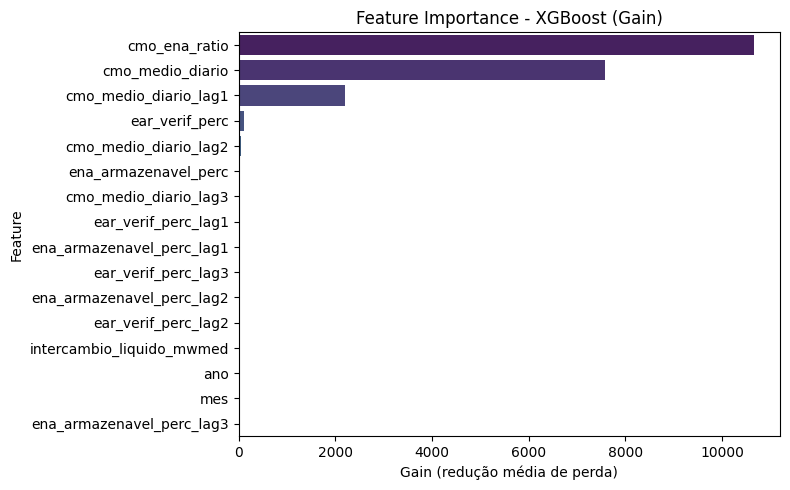

In [568]:
# -------------------------------
# 7. Feature Importance
# -------------------------------
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame([
    {'Feature': k, 'Importance': v} for k, v in importance.items()
]).sort_values('Importance', ascending=False)

print("\nFeature Importance (Gain):")
print(importance_df)

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - XGBoost (Gain)')
plt.xlabel('Gain (redução média de perda)')
plt.tight_layout()
plt.show()

As features de maior relevância foram o ratio que eu criei do cmo com o ena, o cmo e seu lag como esperado. Porém esperava mais impacto das variáveis hídricas.

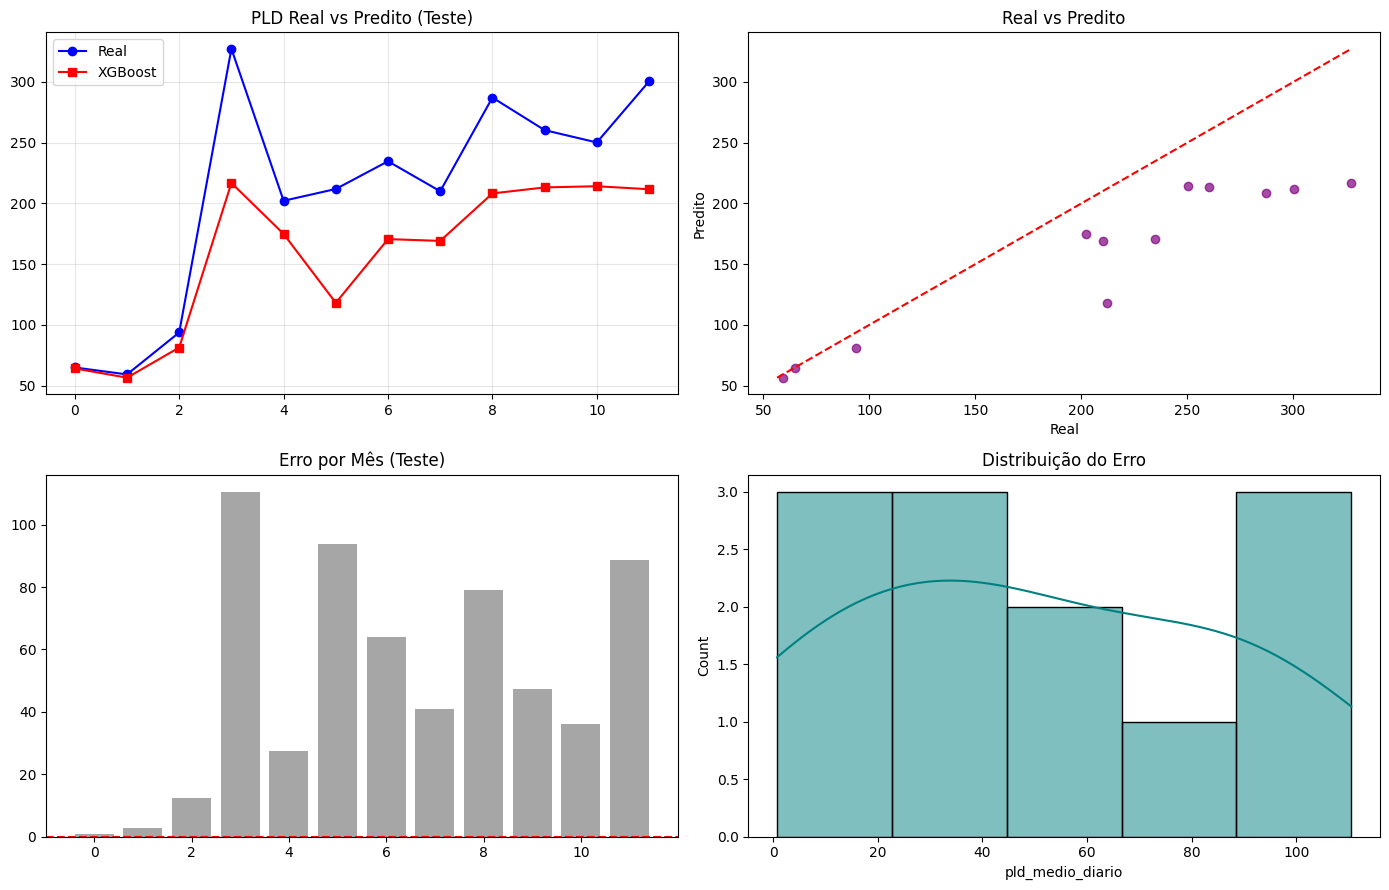

In [569]:
# -------------------------------
# 9. Gráficos: Real vs Predito
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Série temporal
axes[0,0].plot(y_test.values, label='Real', marker='o', color='blue')
axes[0,0].plot(y_pred_test, label='XGBoost', marker='s', color='red')
axes[0,0].set_title('PLD Real vs Predito (Teste)')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Scatter
axes[0,1].scatter(y_test, y_pred_test, alpha=0.7, color='purple')
minv, maxv = min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())
axes[0,1].plot([minv, maxv], [minv, maxv], 'r--')
axes[0,1].set_xlabel('Real')
axes[0,1].set_ylabel('Predito')
axes[0,1].set_title('Real vs Predito')

# Erro
erro = y_test - y_pred_test
axes[1,0].bar(range(len(erro)), erro, color='gray', alpha=0.7)
axes[1,0].axhline(0, color='red', linestyle='--')
axes[1,0].set_title('Erro por Mês (Teste)')

# Distribuição do erro
sns.histplot(erro, kde=True, ax=axes[1,1], color='teal')
axes[1,1].set_title('Distribuição do Erro')

plt.tight_layout()
plt.show()

In [570]:
# -------------------------------
# 10. Comparação com Regressão Linear com features simples
# -------------------------------
from sklearn.linear_model import LinearRegression

# Definindo as features simples para a Regressão Linear
features_simples = ['cmo_medio_diario', 'ena_armazenavel_perc',
                    'ear_verif_perc']

# Selecionando apenas essas colunas do conjunto de treino e teste
X_train_lr = X_train[features_simples]
X_test_lr = X_test[features_simples]

# Ajustando o modelo de Regressão Linear com as features simples
model_lr = LinearRegression()
model_lr.fit(X_train_lr, y_train)
y_pred_lr = model_lr.predict(X_test_lr)

# Calculando o SMAPE para ambos os modelos
smape_xgb = smape(y_test, y_pred_test)
smape_lr = smape(y_test, y_pred_lr)

# Exibindo a comparação
print(f"\n{'='*60}")
print(f"{'COMPARAÇÃO FINAL (SMAPE - TESTE)':^60}")
print(f"{'='*60}")
print(f"  XGBoost:  {smape_xgb:>8.2f}%")
print(f"  Linear:   {smape_lr:>8.2f}%")
print(f"  Dif:      {smape_xgb - smape_lr:>+8.2f} p.p.")
print(f"  → {'XGBoost MELHOR' if smape_xgb < smape_lr else 'Linear melhor'}")


              COMPARAÇÃO FINAL (SMAPE - TESTE)              
  XGBoost:     23.92%
  Linear:      40.86%
  Dif:        -16.95 p.p.
  → XGBoost MELHOR


In [571]:
# Validação Cruzada
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model_cv = xgb.XGBRegressor(**model.get_params())
    model_cv.fit(X_tr, y_tr)
    pred = model_cv.predict(X_val)
    cv_scores.append(smape(y_val, pred))

print(f"SMAPE CV médio: {np.mean(cv_scores):.2f}% ± {np.std(cv_scores):.2f}%")

SMAPE CV médio: 32.70% ± 29.09%


O modelo XGBoost para a previsão do PLD supera a regressão linear em 17% em relação ao erro (SMAPE) e possui um margem de erro razoável (23,92%).

O modelo pode ser aprimorado adicionando mais variáveis de outras fontes de energia e de demanda por energia elétrica.